# SynthMags_LSSTobs

Based on Lynne Jones code here: https://rubin-obs.slack.com/archives/C0824CTA335/p1732311332938929

See also:  https://github.com/lsst/rubin_sim_notebooks/blob/main/photometry/calculating_magnitudes.ipynb

Created: 2024.12.05

## 1. Initial Setup...

### 1.1 Import useful python packages

In [1]:
import pylab as plt
import warnings
import os
import numpy
import pandas as pd
from astropy.io import fits
from astropy import units as u
import rubin_sim.phot_utils as pt
import syseng_throughputs as st

# Set a standard figure size to use
plt.rcParams['figure.figsize'] = (8.0, 8.0)

# Set filter warnings to "ignore" to avoid a lot of "logorrhea" to the screen:
warnings.filterwarnings("ignore")

/home/d/dltucker/WORK/GitHub/syseng_throughputs/syseng_throughputs/bandpassUtils.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### 1.2 Include user input

In [2]:
# Set environment variable to point to location of the rubin_sim_data 
#  (per Lynne Jones' Slack message on the #sciunit-photo-calib channel from 26 Nov 2024):
os.environ["RUBIN_SIM_DATA_DIR"] = "/sdf/data/rubin/shared/rubin_sim_data"

# Which CalSpec C26202 spectrum FITS file to to use?
sedfile = '~/Downloads/c26202_stiswfcnic_007.fits'
#sedfile = '~/Downloads/c26202_mod_007.fits'
#sedfile = '~/Downloads/c26202_stiswfcnic_006.fits'
#sedfile = '~/Downloads/c26202_mod_008.fits'
#sedfile = '~/Downloads/c26202_stiswfcnic_007.fits'


# Plot symbol colors to use for ugrizy
plot_filter_colors_white_background = {'u': '#0c71ff', 'g': '#49be61', 'r': '#c61c00', 'i': '#ffc200', 'z': '#f341a2', 'y': '#5d0000'}

### 1.3 Define useful classes and functions

In [3]:
# Useful class to stop "Run All" at a cell 
#  containing the command "raise StopExecution"
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

# 2 Calculate synthetic magnitudes

ColDefs(
    name = 'WAVELENGTH'; format = '1E'; unit = 'angstroms'; disp = 'G15.7'
    name = 'FLUX'; format = '1E'; unit = 'flam'; disp = 'G15.7'
)


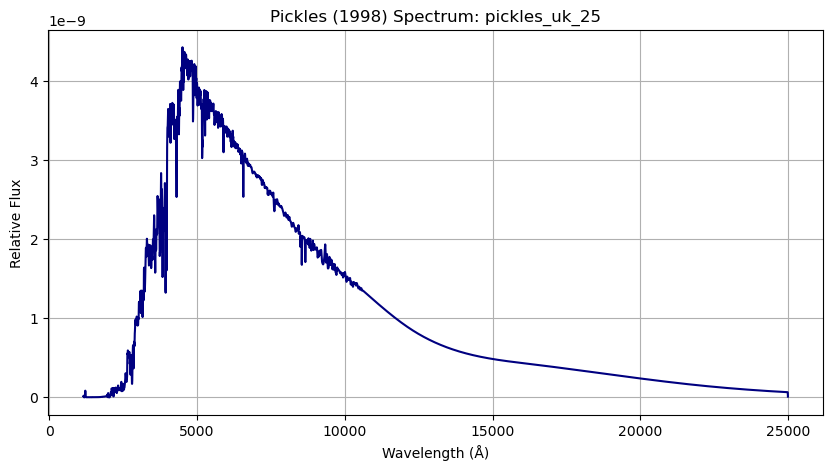

In [18]:

# Open the FITS file
filename = "/home/d/dltucker/DATA/pickles/dat_uvk/pickles_uk_25.fits"
with fits.open(filename) as hdul:
    data = hdul[1].data   # the binary table

    # Extract the two columns (column names may vary, but usually wavelength + flux)
    print(data.columns)   # check the actual names
    wavelength = data.field(0)   # or data['WAVELENGTH']
    flux       = data.field(1)   # or data['FLUX']

# Plot with matplotlib
plt.figure(figsize=(10,5))
plt.plot(wavelength, flux, color="navy")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Relative Flux")
plt.title("Pickles (1998) Spectrum: pickles_uk_25")
plt.grid(True)
plt.show()


### 2.1 Read the file 


In [21]:
#seddata = fits.getdata(sedfile)
seddata = fits.getdata('/home/d/dltucker/DATA/pickles/dat_uvk/pickles_uk_25.fits')
seddata

FITS_rec([( 1150., 1.4092636e-11), ( 1155., 1.9935120e-11),
          ( 1160., 1.5465689e-11), ..., (24990., 6.4302244e-11),
          (24995., 5.6186923e-11), (25000., 8.0235159e-12)],
         dtype=(numpy.record, [('WAVELENGTH', '>f4'), ('FLUX', '>f4')]))

### 2.2 Translate to rubin_sim format

In [22]:
wavelen = seddata['WAVELENGTH'] * u.angstrom.to(u.nanometer) # This is in angstroms - need in nanometers
flambda = seddata['FLUX'] / (u.angstrom.to(u.nanometer)) # this is in erg/sec/cm^^2/ang but we want /nm 

sed = pt.Sed(wavelen=wavelen, flambda=flambda)

In [24]:
flambda

array([1.4092635e-10, 1.9935119e-10, 1.5465690e-10, ..., 6.4302241e-10,
       5.6186922e-10, 8.0235159e-11], shape=(4771,), dtype=float32)

### 2.3 Change detectors from (default) LSST to ComCam

In [25]:
defaultDirs = st.setDefaultDirs()
defaultDirs['detector'] = defaultDirs['detector'].replace('/joint_minimum', '/itl')
hardware, system = st.buildHardwareAndSystem(defaultDirs)


### 2.4 Define the photometric paramters to use.

In [26]:
phot_params = pt.PhotometricParameters(exptime=30, nexp=1, gain=1.0)

### 2.5 Calculate synthetic mags (and counts in electrons)

In [27]:
mags = {}
counts = {}
counts_100k = {}
for f in 'ugrizy':
    mags[f] = sed.calc_mag(system[f])
    counts[f] = sed.calc_adu(system[f], phot_params)
    counts_100k[f] = counts[f]/100000

#pd.DataFrame([mags, counts, counts_100k], index=['AB mag', 'total counts', 'counts(100k)'])
for f in 'ugrizy':
    print(f, mags[f], counts[f], counts_100k[f])

u 1.4075528558949753 306591397156.11786 3065913.9715611786
g 0.24197004151503343 5845221096014.119 58452210.96014119
r -0.1440033623934589 7398606923592.351 73986069.2359235
i -0.304652241136635 7266194884543.017 72661948.84543017
z -0.3417974240869608 5345962192077.65 53459621.9207765
y -0.36852353263105364 2320804319885.348 23208043.19885348


In [9]:
# Stop here
raise StopExecution

In [10]:
# Replace with the actual filename you uploaded
filename = "/home/d/dltucker/DATA/pickles/dat_uvk/pickles_uk_25.fits"

# Open the FITS file
hdul = fits.open(filename)

# Inspect the structure
hdul.info()


Filename: /home/d/dltucker/DATA/pickles/dat_uvk/pickles_uk_25.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   ()      
  1                1 BinTableHDU     19   4771R x 2C   [1E, 1E]   


In [12]:
hdul[1].data

FITS_rec([( 1150., 1.4092636e-11), ( 1155., 1.9935120e-11),
          ( 1160., 1.5465689e-11), ..., (24990., 6.4302244e-11),
          (24995., 5.6186923e-11), (25000., 8.0235159e-12)],
         dtype=(numpy.record, [('WAVELENGTH', '>f4'), ('FLUX', '>f4')]))

In [13]:
from astropy.io import fits

filename = "/home/d/dltucker/DATA/pickles/dat_uvk/pickles_uk_25.fits"
hdul = fits.open(filename)

# Look at the column names in the binary table
print(hdul[1].columns)


ColDefs(
    name = 'WAVELENGTH'; format = '1E'; unit = 'angstroms'; disp = 'G15.7'
    name = 'FLUX'; format = '1E'; unit = 'flam'; disp = 'G15.7'
)


In [16]:
data = hdul[1].data

wavelength = data.field(0)   # or data['WAVELENGTH']
flux       = data.field(1)   # or data['FLUX']


ColDefs(
    name = 'WAVELENGTH'; format = '1E'; unit = 'angstroms'; disp = 'G15.7'
    name = 'FLUX'; format = '1E'; unit = 'flam'; disp = 'G15.7'
)


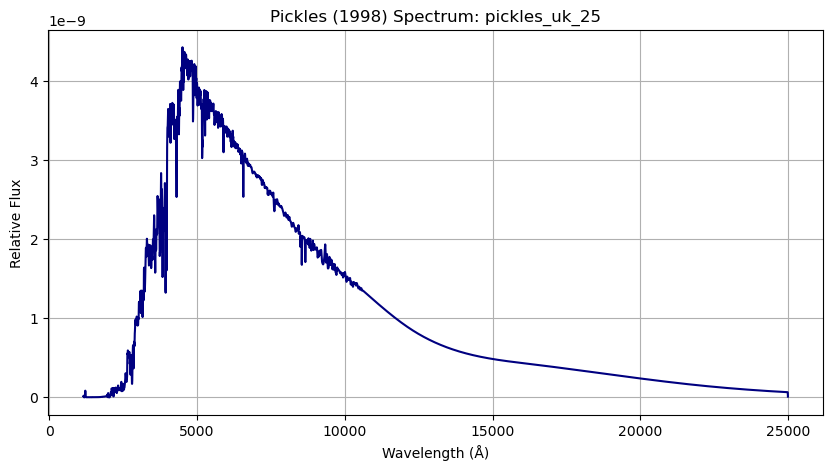

In [17]:
from astropy.io import fits
import matplotlib.pyplot as plt

# Open the FITS file
filename = "/home/d/dltucker/DATA/pickles/dat_uvk/pickles_uk_25.fits"
with fits.open(filename) as hdul:
    data = hdul[1].data   # the binary table

    # Extract the two columns (column names may vary, but usually wavelength + flux)
    print(data.columns)   # check the actual names
    wavelength = data.field(0)   # or data['WAVELENGTH']
    flux       = data.field(1)   # or data['FLUX']

# Plot with matplotlib
plt.figure(figsize=(10,5))
plt.plot(wavelength, flux, color="navy")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Relative Flux")
plt.title("Pickles (1998) Spectrum: pickles_uk_25")
plt.grid(True)
plt.show()


In [31]:
import glob
import pandas as pd
from astropy.io import fits
import astropy.units as u

# Function to compute ugrizy mags for one Pickles FITS file
def compute_mags(fname, system, phot_params):
    seddata = fits.getdata(fname)

    # Convert wavelength (Å → nm) and flux (per Å → per nm)
    wavelen = seddata['WAVELENGTH'] * u.angstrom.to(u.nanometer)
    flambda = seddata['FLUX'] / (u.angstrom.to(u.nanometer))

    sed = pt.Sed(wavelen=wavelen, flambda=flambda)

    mags = {}
    for f in 'ugrizy':
        mags[f] = sed.calc_mag(system[f])
    return mags

# Build the hardware/system once outside the loop
defaultDirs = st.setDefaultDirs()
#defaultDirs['detector'] = defaultDirs['detector'].replace('/joint_minimum', '/itl')
hardware, system = st.buildHardwareAndSystem(defaultDirs)

phot_params = pt.PhotometricParameters(exptime=30, nexp=1, gain=1.0)

# Loop over all Pickles FITS files
rows = []
for fname in glob.glob("/home/d/dltucker/DATA/pickles/dat_uvk/pickles_uk_*.fits"):
    mags = compute_mags(fname, system, phot_params)
    row = {"filename": fname}
    row.update(mags)
    rows.append(row)

# Assemble into a DataFrame
df = pd.DataFrame(rows)

# If you want just the basename instead of full path:
df['filename'] = df['filename'].apply(lambda x: x.split('/')[-1])

print(df.head())


              filename         u         g         r         i         z  \
0   pickles_uk_28.fits  1.415250  0.282172 -0.151664 -0.274645 -0.310422   
1  pickles_uk_120.fits  0.443792 -0.019563  0.073592  0.227483  0.320665   
2   pickles_uk_48.fits  0.563937 -0.124064  0.133849  0.342972  0.468549   
3  pickles_uk_101.fits  2.451824  0.564145 -0.508207 -2.489465 -3.442479   
4   pickles_uk_13.fits  0.885363  0.026626  0.040445  0.127094  0.195440   

          y  
0 -0.282507  
1  0.420275  
2  0.539136  
3 -4.040069  
4  0.207712  


In [32]:
df

,filename,u,g,r,i,z,y
0,pickles_uk_28.fits,1.415250,0.282172,-0.151664,-0.274645,-0.310422,-0.282507
1,pickles_uk_120.fits,0.443792,-0.019563,0.073592,0.227483,0.320665,0.420275
2,pickles_uk_48.fits,0.563937,-0.124064,0.133849,0.342972,0.468549,0.539136
3,pickles_uk_101.fits,2.451824,0.564145,-0.508207,-2.489465,-3.442479,-4.040069
4,pickles_uk_13.fits,0.885363,0.026626,0.040445,0.127094,0.195440,0.207712
...,...,...,...,...,...,...,...
126,pickles_uk_57.fits,2.290844,0.435105,-0.274958,-0.519025,-0.644865,-0.690901
127,pickles_uk_124.fits,1.808663,0.346676,-0.185002,-0.275903,-0.260580,-0.277470
128,pickles_uk_49.fits,0.740256,-0.058025,0.099301,0.250839,0.359637,0.391623
129,pickles_uk_14.fits,0.957876,0.088075,-0.011078,0.003002,0.078315,0.118822


In [29]:
df

,filename,u,g,r,i,z,y
0,pickles_uk_28.fits,1.415197,0.282171,-0.151664,-0.274645,-0.310522,-0.282152
1,pickles_uk_120.fits,0.443791,-0.019562,0.073593,0.227483,0.320703,0.420770
2,pickles_uk_48.fits,0.563936,-0.124063,0.133849,0.342973,0.468603,0.539911
3,pickles_uk_101.fits,2.446928,0.564014,-0.508215,-2.489477,-3.444852,-4.042546
4,pickles_uk_13.fits,0.885351,0.026627,0.040445,0.127094,0.195468,0.207931
...,...,...,...,...,...,...,...
126,pickles_uk_57.fits,2.290643,0.435101,-0.274958,-0.519026,-0.645112,-0.691298
127,pickles_uk_124.fits,1.808582,0.346674,-0.185002,-0.275903,-0.260644,-0.277450
128,pickles_uk_49.fits,0.740250,-0.058024,0.099301,0.250840,0.359604,0.392197
129,pickles_uk_14.fits,0.957860,0.088075,-0.011078,0.003002,0.078564,0.118869


In [33]:
df.to_csv("/home/d/dltucker/DATA/synthMags.LSSTCam.pickles.csv")